In [19]:
%matplotlib inline

In [20]:
import os
import shutil
import random
import time
import math
import cv2
import re
import numpy as np
from utils import show_image

In [21]:
CWD = '/'.join(os.getcwd().replace('\\', '/').split('/')[:-1])
CWD

'E:/Cloud/GIT/CVEET'

In [22]:
def getImagesOfInterest(path):
    """Return a list of images + their respective xml bbox+labels file."""
    files = []
    for filename in os.listdir('../images/raw/'):
        f = '{}/images/raw/{}.xml'.format(CWD, filename[:-4]) # Target file for obj. and bboxes.
        if (not filename.endswith(".jpg")) or (not os.path.isfile(f)):
            continue
        files.append(filename[:-4])
    return files

Move raw images plus their respective xml/json bounding box + object files to train / test / valid

In [23]:
def createTrainTestData(perc=0.8, path='../images/raw/'):
    files = getImagesOfInterest(path)
    random.shuffle(files)
    items = int(len(files)*perc)
    train = files[:items]
    test = files[items:]
    print(len(files), '--->', len(train), len(test))
    
    for f in train:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/train/{}.jpg'.format(f))
        shutil.copyfile('../images/raw/{}.xml'.format(f), '../images/train/{}.xml'.format(f))
        #break
    
    for f in test:
        shutil.copyfile('../images/raw/{}.jpg'.format(f), '../images/test/{}.jpg'.format(f))
        shutil.copyfile('../images/raw/{}.xml'.format(f), '../images/test/{}.xml'.format(f))
        #break
        
    print("Finished train-test split, using", perc, '% train and', 1-perc, 'test.')

In [24]:
#createTrainTestData(0.9)

Crop and save regions from images, based on respective XML file.

In [25]:
def parseBBOXFile(file):
    with open(file, 'r') as f:
        content = []
        for i, line in enumerate(f):
            if i <= 12: # Skip these lines.
                continue
            line = line.strip().lower().replace('\n', '').replace('\r', '').replace('\t', '')
            line = line.replace('</object>', '')
            content.append(line)
        return ''.join(content[:-1]).split('<object>')[1:] # Return content - last line.
    
def getTagValue(text, tag):
    start, end = text.find('<{}>'.format(tag)), text.find('</{}>'.format(tag))
    return text[(start+len(tag)+2):end]

In [26]:
def createImagesFromBBOX(path='../images/raw/'):
    vehicles = {}
    for f in getImagesOfInterest(path):
        jpg, xml = '{}{}.jpg'.format(path, f), '{}{}.xml'.format(path, f)
        img = cv2.imread(jpg, cv2.IMREAD_COLOR)
        for obj in parseBBOXFile(xml):
            label = getTagValue(obj, 'name')
            vehicles[label] = vehicles.get(label, 0) + 1
            xmin = int(getTagValue(obj, 'xmin'))
            ymin = int(getTagValue(obj, 'ymin'))
            xmax = int(getTagValue(obj, 'xmax'))
            ymax = int(getTagValue(obj, 'ymax'))
            print(label, xmin, ymin, xmax, ymax)
            img_region = img[ymin:ymax, xmin:xmax].copy()
            show_image(img_region, size=(2,1))
            cv2.imwrite('../images/raw_classify/{}_{}.jpg'.format(label, vehicles[label]), img_region)
            
        break # Do this if we need to train a classifier.

car 486 295 509 315


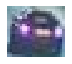

car 421 239 429 246


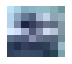

car 411 232 419 239


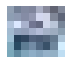

car 401 228 406 233


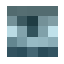

car 305 236 318 246


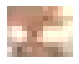

In [27]:
createImagesFromBBOX()

In [28]:
def getNumObjects(path='../images/raw/'):
    num = 0
    for f in getImagesOfInterest(path):
        xml = '{}{}.xml'.format(path, f)
        num += len(parseBBOXFile(xml))
    return num

In [29]:
getNumObjects()

1441